While in **PCA** the number of components is bounded by the number of features, in **KernelPCA** the number of components is bounded by the number of samples. Many real-world datasets have large number of samples! In these cases finding all the components with a full kPCA is a waste of computation time, as data is mostly described by the first few components (e.g. `n_components<=100`). In other words, the centered Gram matrix that is eigendecomposed in the Kernel PCA fitting process has an effective rank that is much smaller than its size. This is a situation where approximate eigensolvers can provide speedup with very low precision loss.

more [here](https://scikit-learn.org/stable/modules/decomposition.html#kernel-pca)

Kernel Principal component analysis (KPCA) [1](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://people.eecs.berkeley.edu/~wainwrig/stat241b/scholkopf_kernel.pdf).

Non-linear dimensionality reduction through the use of kernels (see [Pairwise metrics, Affinities and Kernels](https://scikit-learn.org/stable/modules/metrics.html#metrics)).

It uses the scipy.linalg.eigh LAPACK implementation of the full SVD or the scipy.sparse.linalg.eigsh ARPACK implementation of the truncated SVD, depending on the shape of the input data and the number of components to extract. It can also use a randomized truncated SVD by the method proposed in [3](https://arxiv.org/abs/0909.4061), see eigen_solver.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

## Preparing the data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model Kernel PCA

In [8]:
class ModelKernelPCA:
    
    def __init__(self, n_components):
        self.n_components=n_components
        
    # spe: squared prediction errors
    def spe (self, X, X_pred): 
        return np.sum((X-X_pred)**2, axis=1)
   
    def train(self, df_train):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        # Simply set n_components to be float, and it will be used as a 
        # lower bound of explained variance.
        if self.n_components == 0:
            self.m = sklearn.decomposition.KernelPCA(fit_inverse_transform=True)
        else:
            self.m = sklearn.decomposition.KernelPCA(n_components=self.n_components,
                                                     fit_inverse_transform=True)
            # Learn the inverse transform for non-precomputed kernels (i.e. learn
            # to find the pre-image of a point). This method is based on [2]
           
        X_train = sklearn.preprocessing.scale(df_train)
        # Transform data back to its original space.
        X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train)) 
        
        return self.spe(X_train, X_train_pred) # return spe
            
    def test(self, df_test):
        
        # standardizing test data according to the mu and std of training set
        X_test = np.array((df_test-self.mu_train)/self.std_train) 
        X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

some information related fit_inverse_transform in the Kernel PCA here is the papaer source [[2]](https://citeseerx.ist.psu.edu/messages/downloadsexceeded.html)
here from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#r396fc7d924b8-2)

# Training the data

In [9]:
models = {'KernelPCA': ModelKernelPCA(0)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

In [10]:
detection_limits

{'KernelPCA': 0.015187648609949768}

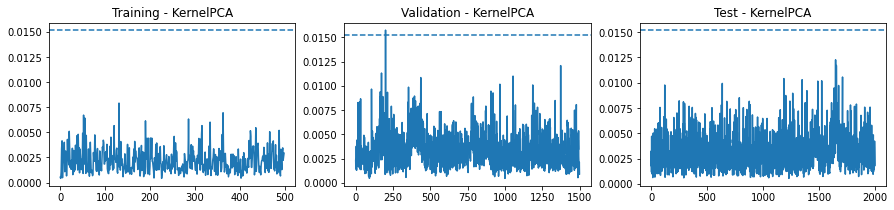

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - KernelPCA')
plt.axhline(detection_limits['KernelPCA'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - KernelPCA')
plt.axhline(detection_limits['KernelPCA'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - KernelPCA')
plt.axhline(detection_limits['KernelPCA'], ls = '--')

# Testing the Data

KernelPCA    59.0375
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
KernelPCA,99.5,95.5,0.0,0.0,99.875,100.0,22.25,91.625,0.0,67.5,0.25,97.625,87.875,26.625,0.0,81.75,58.25,92.375,78.0,81.75


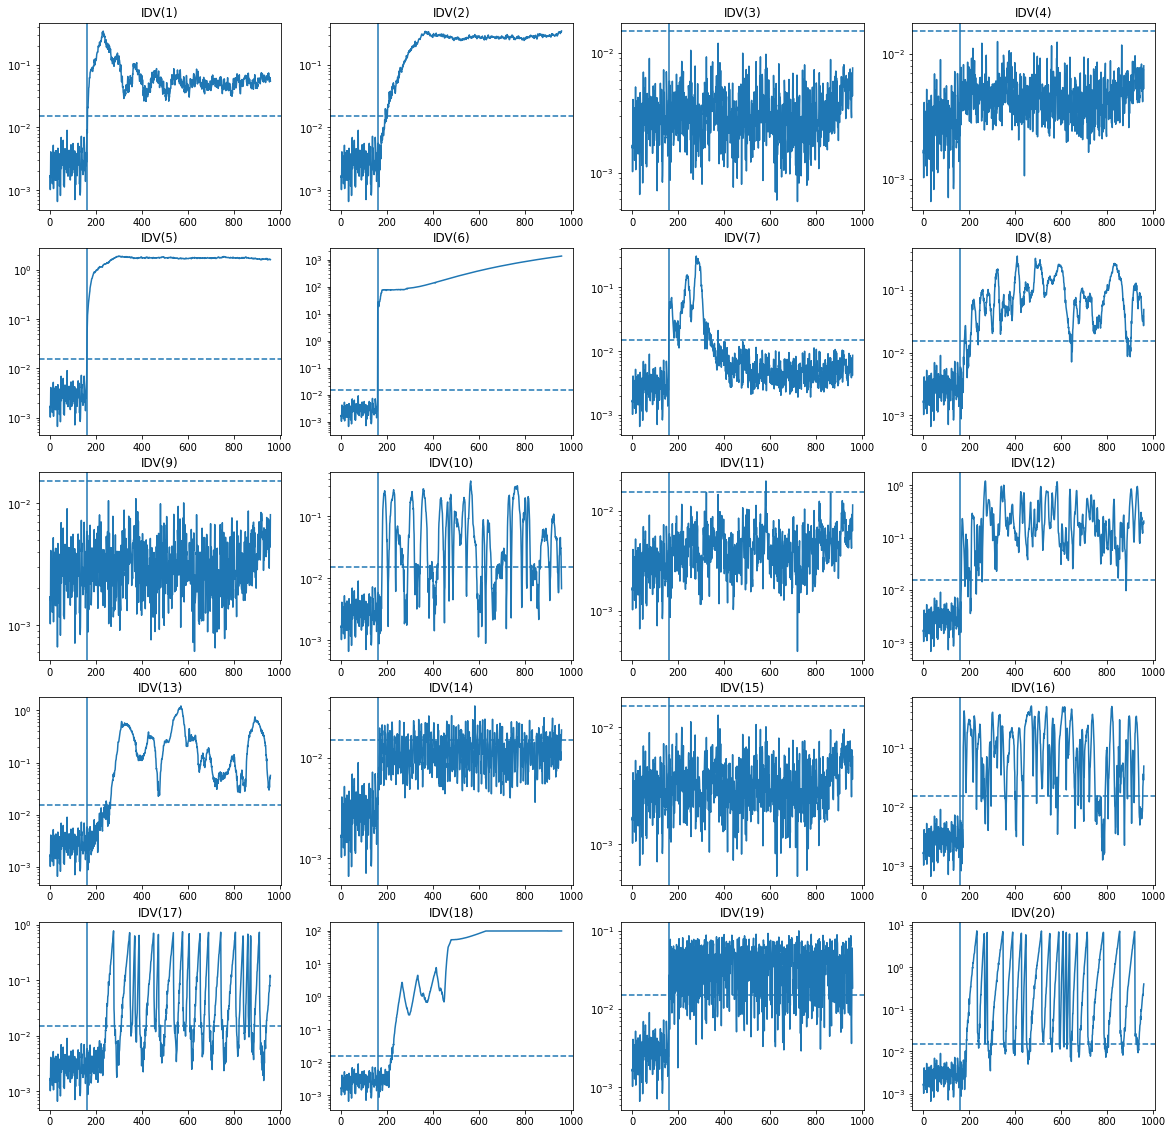

In [12]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

# Training the data with 30 n_components in the model

In [13]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
# actually this code up removing the warning sign from below line of code
#https://stackoverflow.com/questions/14861891/runtimewarning-invalid-value-encountered-in-divide

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

this kind of error
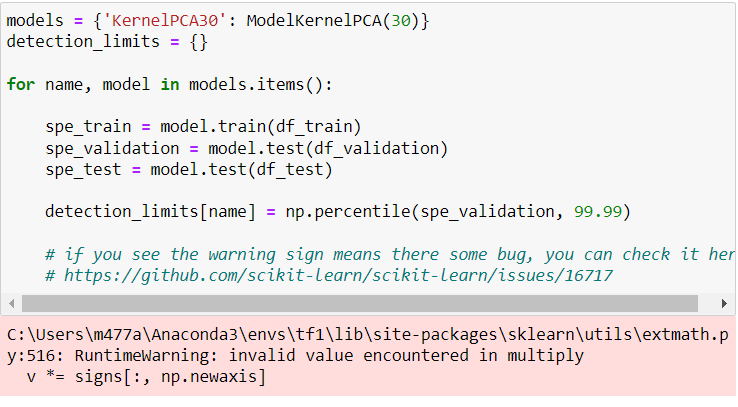

In [14]:
models = {'KernelPCA30': ModelKernelPCA(30)}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    # if you see the warning sign means there some bug, you can check it here
    # https://github.com/scikit-learn/scikit-learn/issues/16717

In [15]:
detection_limits

{'KernelPCA30': 25.44578142588978}

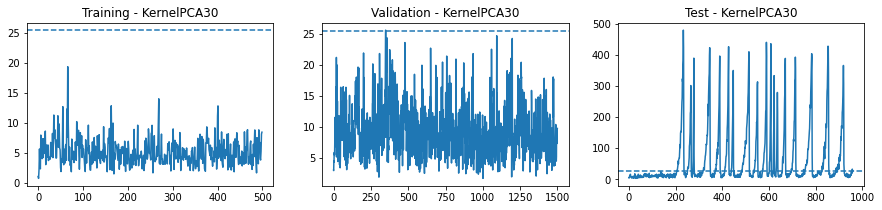

In [16]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(spe_train)
plt.title(f'Training - KernelPCA30')
plt.axhline(detection_limits['KernelPCA30'], ls = '--')

plt.subplot(1,3,2)
plt.plot(spe_validation)
plt.title(f'Validation - KernelPCA30')
plt.axhline(detection_limits['KernelPCA30'], ls = '--')

plt.subplot(1,3,3)
plt.plot(spe_test)
plt.title(f'Test - KernelPCA30')
plt.axhline(detection_limits['KernelPCA30'], ls = '--')

# Testing the new model

KernelPCA30    58.99375
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
KernelPCA30,99.625,98.0,0.75,87.25,15.625,100.0,99.25,96.75,0.75,12.25,37.375,96.375,90.5,99.875,0.875,22.625,81.625,92.5,2.625,45.25


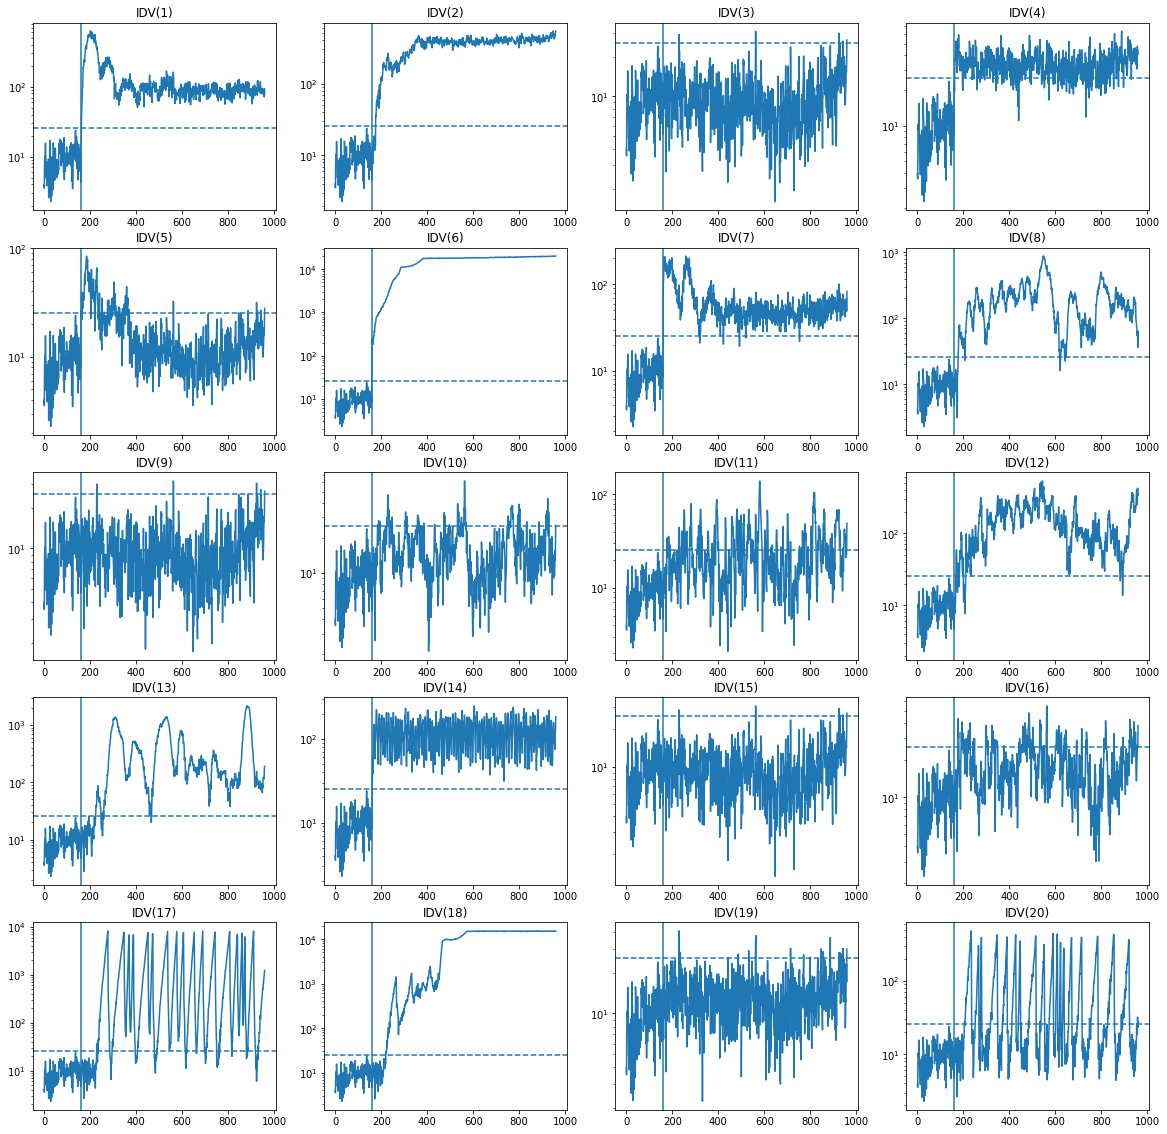

In [17]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

In [18]:
# fdr_df.to_csv('./experimental_result_csv/kpca30.csv')

## Lag variables

In [19]:
def apply_lag (df, lag = 1):
       
    from statsmodels.tsa.tsatools import lagmat
    array_lagged = lagmat(df, maxlag=lag,
                          trim="forward", original='in')[lag:,:]  
    new_columns = []
    for l in range(lag):
        new_columns.append(df.columns+'_lag'+str(l+1))
    columns_lagged = df.columns.append(new_columns)
    index_lagged = df.index[lag:]
    df_lagged = pd.DataFrame(array_lagged, index=index_lagged,
                             columns=columns_lagged)
       
    return df_lagged  

## Noise filtering

In [20]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

## Adding lag variables

kPCA_lag1    59.756250
kPCA_lag2    61.051314
kPCA_lag3    63.020050
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
kPCA_lag1,99.500000,98.000000,0.25,99.875,13.000000,100.0,100.0,97.750000,0.25,5.875000,59.375000,97.375000,90.500000,100.0,0.125,12.000000,81.750000,92.125000,3.000000,44.375000
kPCA_lag2,99.624531,98.122653,0.00,100.000,16.645807,100.0,100.0,97.872340,0.00,8.510638,66.332916,98.372966,91.239049,100.0,0.000,14.267835,82.978723,92.615770,8.760951,45.682103
kPCA_lag3,99.749373,98.621554,0.00,100.000,21.303258,100.0,100.0,97.994987,0.00,13.032581,73.433584,98.746867,92.982456,100.0,0.000,21.804511,84.962406,92.982456,15.664160,49.122807


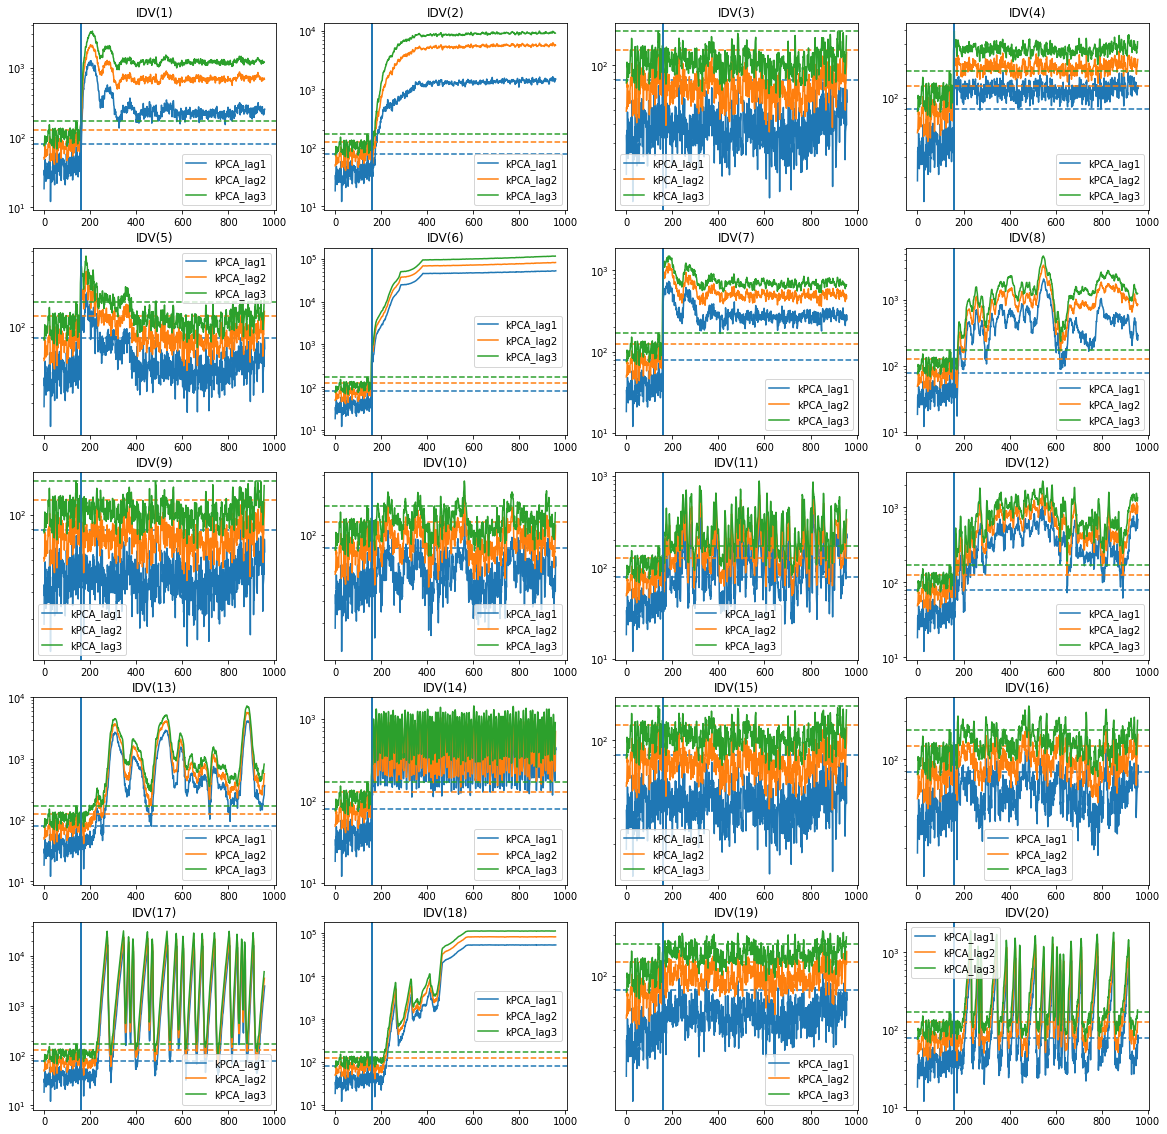

In [21]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'kPCA_lag1':ModelKernelPCA(30), 'kPCA_lag2': ModelKernelPCA(30), 'kPCA_lag3': ModelKernelPCA(30)}
lags = {'kPCA_lag1': 1, 'kPCA_lag2': 2, 'kPCA_lag3': 3}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(apply_lag(df_train,lags[name]))
    spe_validation = model.test(apply_lag(df_validation,lags[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = apply_lag(test_faulty[(test_faulty.faultNumber==i+1) & 
                                        (test_faulty.simulationRun==1)].iloc[:,3:], lags[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [22]:
# fdr_df.to_csv('./experimental_result_csv/kpcalag.csv')

## Filter noise

WS_10     66.22500
WS_50     61.41250
WS_100    57.81875
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,99.250,98.125,0.625,99.625,99.5,99.875,99.875,97.625,1.000,25.625,79.875,98.625,93.625,47.500,0.75,31.250,91.000,93.125,1.125,66.500
WS_50,98.625,97.125,0.125,98.500,99.0,99.500,99.375,96.750,0.250,15.875,56.375,89.375,92.000,1.625,0.00,7.875,90.375,91.875,0.500,93.125
WS_100,98.250,96.250,3.125,95.875,98.5,99.375,98.750,91.125,3.125,6.250,11.875,86.500,89.875,0.500,0.00,1.125,90.000,91.125,2.375,92.375


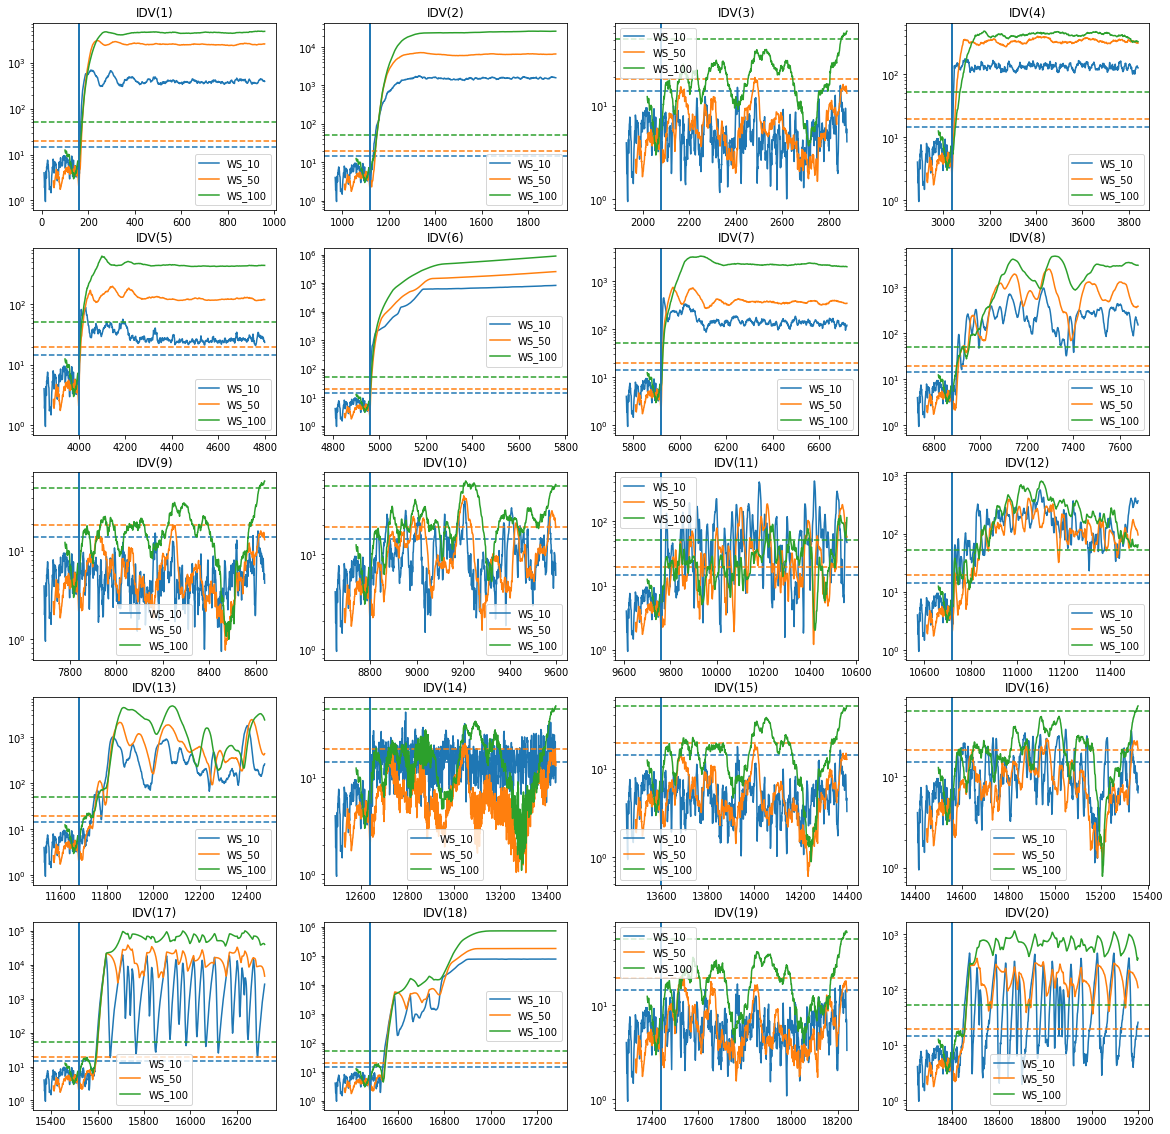

In [23]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelKernelPCA(30), 'WS_50': ModelKernelPCA(30), 'WS_100': ModelKernelPCA(30)}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T

In [24]:
# fdr_df.to_csv('./experimental_result_csv/kpcanf.csv')